This dataset describes the monthly number of sales of shampoo over a 3-year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

In [36]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

Using TensorFlow backend.


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


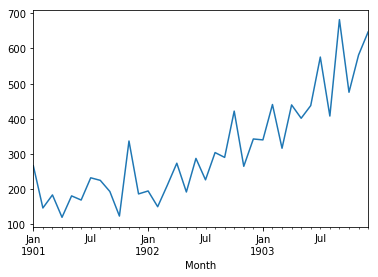

In [12]:
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv',  sep=',', header=0, engine='python', skipfooter=2, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# summarize first few rows
print(series.head())
# line plot
series.plot()
pyplot.show()

In [13]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

## Persistence Model Forecast

Bench-model: The persistence forecast is where the observation from the prior time step (t-1) is used to predict the observation at the current time step (t).

RMSE: 136.761


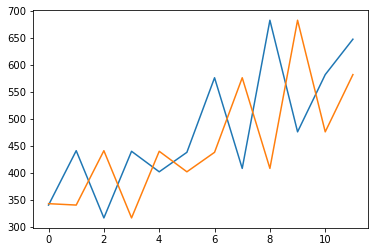

In [16]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    predictions.append(history[-1])
    # observation
    history.append(test[i])

rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

## LSTM 

LSTMs expect data to be within the scale of the activation function used by the network.

The default activation function for LSTMs is the hyperbolic tangent (tanh), which outputs values between -1 and 1. This is the preferred range for the time series data

Samples: These are independent observations from the domain, typically rows of data.  
Time steps: These are separate time steps of a given variable for a given observation.  
Features: These are separate measures observed at the time of observation.

By default, the samples within an epoch are shuffled prior to being exposed to the network. Again, this is undesirable for the LSTM because we want the network to build up state as it learns across the sequence of observations. We can disable the shuffling of samples by setting “shuffle” to “False“.

In [21]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [22]:
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


In [40]:
#There is a structure in the data that is dependent on the time. Specifically, there is an increasing trend in the data.  
#Stationary data is easier to model and will very likely result in more skillful forecasts.
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [37]:
# scale train and test data to [-1, 1]
#The test data is scaled using the fit of the scaler on the training data, as is required to ensure the min/max 
#values of the test data do not influence the model.
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [38]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [39]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [41]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [42]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.66331619],
       [ 0.03953019],
       [-0.33900851],
       [ 0.20318207],
       [-0.32538414],
       [-0.11721222],
       [-0.49942297],
       [-0.20930114],
       [ 0.21582469],
       [ 0.71892524],
       [-0.87888801],
       [ 0.00227767],
       [-0.12496701],
       [ 0.23599979],
       [-0.17770791],
       [-0.4882198 ],
       [ 0.31293663],
       [-0.38225088],
       [ 0.20749626],
       [-0.27347422],
       [ 0.01910427],
       [-0.78025973],
       [ 0.26374623]], dtype=float32)

In [43]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=285.165502, Expected=339.700000
Month=2, Predicted=323.176131, Expected=440.400000
Month=3, Predicted=330.677952, Expected=315.900000
Month=4, Predicted=402.245971, Expected=439.300000
Month=5, Predicted=336.589598, Expected=401.300000
Month=6, Predicted=407.394497, Expected=437.400000
Month=7, Predicted=440.158155, Expected=575.500000
Month=8, Predicted=428.530141, Expected=407.600000
Month=9, Predicted=486.069840, Expected=682.000000
Month=10, Predicted=409.614270, Expected=475.300000
Month=11, Predicted=468.741866, Expected=581.300000
Month=12, Predicted=368.923215, Expected=646.900000


Test RMSE: 120.690


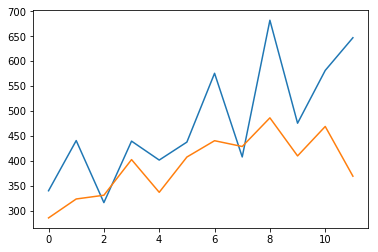

In [44]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()